# <div align="center">Training the different algorithms with the dominant colors data<div/><div align="center">in CIELAB<div/>

In [1]:
CSV_DIR = './colors_LAB_200.csv' #colors.csv #colors_LAB.csv #colors_LAB_512.csv #colors_RGB.csv #colors_RGB_512.csv

tf_model1= './Models/colors_model.tflite'
tf_model2= './Models/colors_model2.tflite'

MAX_SIZE = (30, 30) #(512, 512) #(30, 30) #None
CLUSTERS = 4

### _MENU_
1. **LOAD DATA**
2. **SPLIT DATA**
3. **NORMALIZE DATA**
4. **TRAINING AND EVALUATION OF MACHINE LEARNING MODELS**  
    4.1 Logistic Regression (LR)  
    4.2 K-Nearest-Neighbors (KNN)  
    4.3 Decision Trees (DT)  
    4.4 Support Vector Machine (SVM)  
    4.5 Convolutional Neural Network (CNN)  
5. **EXPORT THE BEST MODEL (KNN)**  
    5.1 Export the KNN model using concrete functions of Tensorflow 2  
    5.2 Export the KNN model using session graph of Tensorflow 1
6. **MAKE NEW PREDICTIONS WITH THE EXPORTED MODEL**  
    6.1 Test the KNN exported model trained with the dominant colors of granite image 10714J_P2.jpg  
    6.2 Test the CNN exported model of our previous work trained with all image features of granite image 10714J_P2.jpg

### 1. LOAD DATA

In [2]:
import pandas as pd
data = pd.read_csv(CSV_DIR, header=None)
data.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17
0,11830I_P2_01_02.png,38.280482,0.820646,-2.290804,0.118375,79.442609,-1.104434,-1.981014,0.254500,55.501919,0.059052,-2.478294,0.267550,67.933753,-0.597192,-2.530081,0.359575,Granodiorite
1,12720V_P2.JPG,36.335461,-0.125809,-0.937273,0.097825,78.315572,-0.623724,-2.907428,0.242225,55.348765,-0.372943,-2.140021,0.268775,66.785338,-0.615636,-2.765028,0.391175,Granodiorite
2,10715M_P2_01_02.png,25.917947,-0.052033,-2.328551,0.123200,43.752661,-0.750194,-2.625291,0.184675,68.881471,-0.750495,-2.490155,0.336050,57.046790,-0.684879,-2.777347,0.356075,Granodiorite
3,12723M_P2_01_02.png,29.915507,0.747345,-0.644449,0.152625,52.254458,0.256847,-2.538865,0.227600,79.002953,-0.869440,-2.065535,0.293425,66.661952,-0.359162,-2.564519,0.326350,Granodiorite
4,11830I_P2_01_01.png,41.279193,-2.012781,-2.705846,0.122250,56.574847,-1.186368,-2.579405,0.241375,79.585952,-0.204296,-1.436400,0.281900,68.781938,-0.544802,-1.992616,0.354475,Granodiorite


In [3]:
#data = data[data[17] != 'Diorite'] # Deletes Diorite
#data = data[data[17] != 'Gabbro'] # Deletes Gabbro
#data = data[data[17] != 'Granite'] # Deletes Granite
#data = data[data[17] != 'Granodiorite'] # Deletes Granodiorite
data = data[data[data.columns[-1]] != 'Tonalite'] # Deletes Tonalite
data = data[data[data.columns[-1]] != 'Monzodiorite'] # Deletes Monzodiorite

import numpy as np
x = np.array(data[data.columns[1:-1]])
y = data[data.columns[-1]]

print('x shape:', x.shape, '\ny shape:', y.shape)

x shape: (283, 16) 
y shape: (283,)


In [4]:
from sklearn import preprocessing
encoder = preprocessing.LabelEncoder()
y = encoder.fit_transform(y)
classes_dict = dict(zip( list(range(len(np.unique(y)))), encoder.inverse_transform(list(range(len(np.unique(y))))) ))

#classes_dict = {0: 'Diorite', 1: 'Granite', 2: 'Granodiorite', 3: 'Gabbro'}
#classes_dict = {0: 'Granodiorite', 1: 'Granite', 2: 'Diorite', 3: 'Gabbro'}
#y = np.array([list(classes_dict.keys())[list(classes_dict.values()).index(lbl)] for lbl in data[data.columns[-1]]])

print('Classes dict:', classes_dict)

Classes dict: {0: 'Diorite', 1: 'Gabbro', 2: 'Granite', 3: 'Granodiorite'}


In [5]:
classes, indices, counts = np.unique(y, return_counts=True, return_index=True)
df = pd.DataFrame({'Classes': classes_dict.values(), 'Counts': counts, 'Start index': indices}, classes)
df

,Classes,Counts,Start index
0,Diorite,78,140
1,Gabbro,65,218
2,Granite,70,70
3,Granodiorite,70,0


### 2. SPLIT DATA

In [6]:
# Val = 20%, test = 16%, train = 64%
from sklearn.model_selection import train_test_split as splitter
#xtt, xval, ytt, yval = splitter(x,y,train_size=0.8,random_state=42)
xtrain, xtest, ytrain, ytest = splitter(x,y,train_size=0.8,random_state=42)

### 3. NORMALIZE DATA

In [7]:
from sklearn.preprocessing import MinMaxScaler
normalizer = MinMaxScaler()

xtrainNorm = normalizer.fit_transform(xtrain)
xtestNorm = normalizer.transform(xtest)

In [8]:
test_norms = [xtest[0][f]*normalizer.scale_[f]+normalizer.min_[f] for f in range(16)]
norm = {'Feature value': xtest[0], 'scale': normalizer.scale_, 'min': normalizer.min_, 'norm': test_norms, 'REAL NORM': xtestNorm[0]}
pd.DataFrame(norm)

,Feature value,scale,min,norm,REAL NORM
0,40.899688,0.016420,-0.351575,0.319980,0.319980
1,0.179381,0.136450,0.670286,0.694762,0.694762
2,-2.319806,0.149258,0.828394,0.482143,0.482143
3,0.080275,5.389383,-0.230396,0.202237,0.202237
4,55.411159,0.015745,-0.309983,0.562477,0.562477
5,-0.919866,0.164901,0.715836,0.564149,0.564149
6,-3.417760,0.174755,0.885207,0.287937,0.287937
7,0.269625,8.914642,-1.404725,0.998886,0.998886
8,75.047080,0.015898,-0.334857,0.858209,0.858209
9,-1.907305,0.162648,0.714721,0.404502,0.404502


In [9]:
with open('scales.txt', 'w') as filehandle:
    for listitem in normalizer.scale_:
        filehandle.write('%s\n' % listitem)
with open('mins.txt', 'w') as filehandle:
    for listitem in normalizer.min_:
        filehandle.write('%s\n' % listitem)

### 4. TRAINING AND EVALUATION OF MACHINE LEARNING MODELS

In [10]:
import time
from sklearn import metrics

#### 4.1 - Logistic Regression (LR)

In [11]:
# Logistic Regression (LR)
from sklearn.linear_model import LogisticRegression
logReg = LogisticRegression(solver='lbfgs')
start = time.time()
logReg.fit(xtrainNorm, ytrain)
stop = time.time()

print("<<MODELS REPORT LOG. REGRESSION>>")
print("Logistic Regression score:",logReg.score(xtestNorm, ytest))

predictions = logReg.predict(xtestNorm)
print("Logistic Regression Model accuracy:", metrics.accuracy_score(ytest, predictions))
print(metrics.classification_report(ytest,predictions, target_names=classes_dict.values()))

print(f"Training time: {stop - start} s")

<<MODELS REPORT LOG. REGRESSION>>
Logistic Regression score: 0.7543859649122807
Logistic Regression Model accuracy: 0.7543859649122807
              precision    recall  f1-score   support

     Diorite       0.76      0.76      0.76        17
      Gabbro       0.67      0.77      0.71        13
     Granite       0.86      0.92      0.89        13
Granodiorite       0.73      0.57      0.64        14

    accuracy                           0.75        57
   macro avg       0.75      0.76      0.75        57
weighted avg       0.75      0.75      0.75        57

Training time: 0.0839989185333252 s


#### 4.2 - K-Nearest Neighbors (KNN)

In [12]:
# K-Nearest Neighbors (KNN)
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier(n_neighbors=1)
start = time.time()
knn.fit(xtrainNorm, ytrain)
stop = time.time()

print("<<MODEL REPORT KNN>>")
print("KNN score:",knn.score(xtestNorm, ytest))

predictions = knn.predict(xtestNorm)
print("KNN Model accuracy:", metrics.accuracy_score(ytest, predictions))
print(metrics.classification_report(ytest,predictions, target_names=classes_dict.values()))

print(f"Training time: {stop - start} s")

<<MODEL REPORT KNN>>
KNN score: 0.9298245614035088
KNN Model accuracy: 0.9298245614035088
              precision    recall  f1-score   support

     Diorite       0.94      0.94      0.94        17
      Gabbro       0.86      0.92      0.89        13
     Granite       1.00      0.92      0.96        13
Granodiorite       0.93      0.93      0.93        14

    accuracy                           0.93        57
   macro avg       0.93      0.93      0.93        57
weighted avg       0.93      0.93      0.93        57

Training time: 0.0017790794372558594 s


#### 4.3 - Decision Trees (DT)

In [13]:
# Decision Trees (DT)
from sklearn.tree import DecisionTreeClassifier
decisionTree = DecisionTreeClassifier(class_weight='balanced')
start = time.time()
decisionTree.fit(xtrain, ytrain)
stop = time.time()

print("<<MODEL REPORT DT>>")
print("Decision trees score:",decisionTree.score(xtest, ytest))

predictions = decisionTree.predict(xtest)
print("Decision trees accuracy:", metrics.accuracy_score(ytest, predictions))
print(metrics.classification_report(ytest,predictions, target_names=classes_dict.values()))

print(f"Training time: {stop - start} s")

<<MODEL REPORT DT>>
Decision trees score: 0.7192982456140351
Decision trees accuracy: 0.7192982456140351
              precision    recall  f1-score   support

     Diorite       0.71      0.59      0.65        17
      Gabbro       0.62      0.77      0.69        13
     Granite       0.91      0.77      0.83        13
Granodiorite       0.69      0.79      0.73        14

    accuracy                           0.72        57
   macro avg       0.73      0.73      0.73        57
weighted avg       0.73      0.72      0.72        57

Training time: 0.0071697235107421875 s


#### 4.4 - Support Vector Machines (SVM)

In [14]:
# Support Vector Machines (SVM)
from sklearn.svm import SVC
svmc = SVC(kernel='rbf', gamma='auto')
start = time.time()
svmc.fit(xtrain, ytrain)
stop = time.time()

print("<<MODEL REPORT SVM>>")
print("Support Vector Machines:",svmc.score(xtest, ytest))

predictions = svmc.predict(xtest)
print("Support Vector Machines Model accuracy:", metrics.accuracy_score(ytest, predictions))
print(metrics.classification_report(ytest,predictions, target_names=classes_dict.values()))

print(f"Training time: {stop - start} s")

<<MODEL REPORT SVM>>
Support Vector Machines: 0.7894736842105263
Support Vector Machines Model accuracy: 0.7894736842105263
              precision    recall  f1-score   support

     Diorite       0.92      0.65      0.76        17
      Gabbro       0.68      1.00      0.81        13
     Granite       0.86      0.92      0.89        13
Granodiorite       0.75      0.64      0.69        14

    accuracy                           0.79        57
   macro avg       0.80      0.80      0.79        57
weighted avg       0.81      0.79      0.78        57

Training time: 0.02549290657043457 s


#### 4.5 - Convolutional Neural Network (CNN)

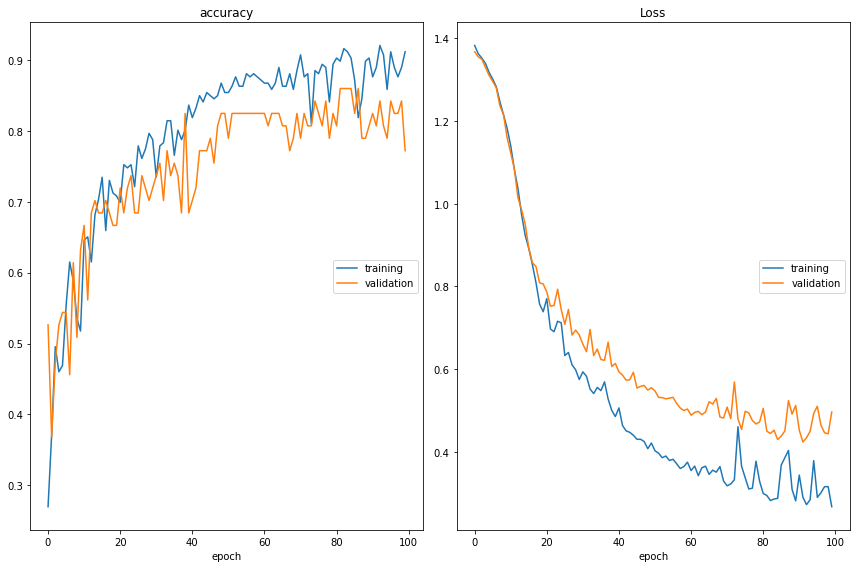

accuracy
	training         	 (min:    0.270, max:    0.920, cur:    0.912)
	validation       	 (min:    0.368, max:    0.860, cur:    0.772)
Loss
	training         	 (min:    0.267, max:    1.383, cur:    0.267)
	validation       	 (min:    0.423, max:    1.368, cur:    0.496)
Accuracy: 0.772 Loss: 0.496
CNN Model accuracy: 0.7719298245614035
              precision    recall  f1-score   support

     Diorite       0.86      0.71      0.77        17
      Gabbro       0.62      1.00      0.76        13
     Granite       0.86      0.92      0.89        13
Granodiorite       0.88      0.50      0.64        14

    accuracy                           0.77        57
   macro avg       0.80      0.78      0.77        57
weighted avg       0.81      0.77      0.76        57

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 16, 32)            96        
__

In [15]:
# Convolutional Neural Network (CNN)
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout, Conv1D, MaxPooling1D
from tensorflow.keras import optimizers
from livelossplot.inputs.tf_keras import PlotLossesCallback

model = Sequential()
model.add(Conv1D(32, kernel_size=2, padding="same", input_shape = (16, 1), activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Conv1D(64, kernel_size=2, padding="same", activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Flatten())
model.add(Dense(64, activation='relu'))
model.add(Dense(len(classes_dict), activation='softmax'))
model.compile(loss='sparse_categorical_crossentropy', optimizer=optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0), metrics=["accuracy"])
# model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

xtrain2 = np.expand_dims(xtrainNorm, 2); ytrain2 = np.expand_dims(ytrain, 1)
xtest2 = np.expand_dims(xtestNorm, 2); ytest2 = np.expand_dims(ytest, 1)

start = time.time()
model.fit(xtrain2, ytrain2, epochs=100, batch_size=32, 
          validation_data=(xtest2, ytest2), callbacks=[PlotLossesCallback()], 
          verbose=1)
stop = time.time()

loss, acc = model.evaluate(xtest2, ytest2, verbose=0)
print('Accuracy: %.3f' % acc, 'Loss: %.3f' % loss)

predictions = np.argmax(model.predict(xtest2), axis=-1)
print("CNN Model accuracy:", metrics.accuracy_score(ytest2, predictions))
print(metrics.classification_report(ytest,predictions, target_names=classes_dict.values()))

model.summary()

print(f"\nTraining time: {stop - start} s")

### 5. EXPORT THE BEST MODEL (KNN)

#### 5.1 - Export the KNN model using concrete functions of Tensorflow 2

In [16]:
import tensorflow as tf

class KNN(tf.Module):
    def __init__(self, n_neighbors):
        self.n_neighbors = n_neighbors; self.xtr = None; self.ytr = None
        
    def fit(self, x, y):
        self.xtr = np.float32(x); self.ytr = y
        
    def score(self, xte, yte):
        accuracy = 0.0
        for i in range (len(xte)):
            prediction = self.predict(xte[i])
            print("Test %d, and the prediction is %s, the real value is %s"%(i, prediction.numpy(), yte[i]))
            if prediction == yte[i]:
                accuracy += 1. / len(xte)
        return accuracy
    
    @tf.function
    def predict(self, value):
        value = tf.cast(value, tf.float32)
        # MANHATTAN distances
        distances = tf.abs(tf.reduce_sum(tf.square(tf.subtract(self.xtr, value)), axis=1))
        # The top k values and their indices. We multiply the distance by -1 to reverse the magnitude of distances,so the largest distance becomes the smallest distance.
        knn_values, knn_indices = tf.nn.top_k(tf.scalar_mul(-1,distances),k=self.n_neighbors)
        # We locate the exact class label set of the k closest matches in the training data
        best_training_labels = tf.gather(self.ytr,knn_indices)
        # We make our prediction based on the class label that appears most frequently
        if self.n_neighbors==1:
            prediction = tf.squeeze([best_training_labels])
        else:
            values, indices, counts = tf.unique_with_counts(best_training_labels)
            max_count_index = tf.argmax(counts,0)
            prediction = tf.gather(values, max_count_index)
        return best_training_labels

knn_model = KNN(1)
start = time.time()
knn_model.fit(xtrainNorm, ytrain)
print('TF-KNN score:', knn_model.score(xtestNorm, ytest))
stop = time.time()
print(knn_model.predict(xtestNorm[0]))

concrete_func = knn_model.predict.get_concrete_function(tf.TensorSpec(shape=[16], dtype=tf.float32))
# Convert the model
converter = tf.lite.TFLiteConverter.from_concrete_functions([concrete_func])
tflite_model = converter.convert()

# Save the model.
with open(tf_model1, 'wb') as f:
    f.write(tflite_model)
    
print(f"\nTraining time: {stop - start} s")

Test 0, and the prediction is [3], the real value is 3
Test 1, and the prediction is [1], the real value is 1
Test 2, and the prediction is [2], the real value is 2
Test 3, and the prediction is [0], the real value is 0
Test 4, and the prediction is [2], the real value is 2
Test 5, and the prediction is [1], the real value is 1
Test 6, and the prediction is [1], the real value is 1
Test 7, and the prediction is [0], the real value is 0
Test 8, and the prediction is [3], the real value is 3
Test 9, and the prediction is [0], the real value is 0
Test 10, and the prediction is [1], the real value is 3
Test 11, and the prediction is [1], the real value is 1
Test 12, and the prediction is [0], the real value is 0
Test 13, and the prediction is [1], the real value is 1
Test 14, and the prediction is [3], the real value is 3
Test 15, and the prediction is [0], the real value is 0
Test 16, and the prediction is [1], the real value is 1
Test 17, and the prediction is [0], the real value is 0
Te

#### 5.2 - Export the KNN model using session graph of Tensorflow 1

In [18]:
# TF KNN
# Resource: https://stackoverflow.com/questions/45787046/tensorflow-knn-how-can-we-assign-the-k-parameter-for-defining-number-of-neighb

import tensorflow.compat.v1 as tf1
tf1.disable_eager_execution()

#tf.float64
knn_size=1
colors = tf1.placeholder(dtype=tf1.float32, shape=[len(xtrainNorm[0])])
# MANHATTAN distances
distances = tf1.abs(tf1.reduce_sum(tf1.square(tf1.subtract(np.float32(xtrainNorm), colors)),axis=1))
# The top k values and their indices. We multiply the distance by -1 to reverse the magnitude of distances,so the largest distance becomes the smallest distance.
knn_values, knn_indices = tf1.nn.top_k(tf.scalar_mul(-1,distances),k=knn_size)
# We locate the exact class label set of the k closest matches in the training data
best_training_labels = tf1.gather(ytrain,knn_indices)

# We make our prediction based on the class label that appears most frequently
if knn_size==1:
    prediction = tf1.squeeze(best_training_labels)
else:
    values, indices, counts = tf1.unique_with_counts(best_training_labels)
    max_count_index = tf1.argmax(counts,0)
    prediction = tf1.gather(values, max_count_index)

# Convert to TF Lite format
with tf1.Session() as sess:
    start = time.time()
    accuracy = 0.0
    for i in range (len(xtestNorm)):
        prediction_value = sess.run([prediction], feed_dict={colors:xtestNorm[i]})
        print("Test %d, and the prediction is %s, the real value is %s"%(i,prediction_value[0],ytest[i]))
        if prediction_value[0] == ytest[i]:
            accuracy += 1. / len(ytest)
    print('TF KNN Accuracy -> ', accuracy * 100, ' %')
    stop = time.time()
    converter = tf1.lite.TFLiteConverter.from_session(sess, [colors], [best_training_labels])
    tflite_model = converter.convert()

# Save the model.
with open(tf_model2, 'wb') as f:
    f.write(tflite_model)
    
print(f"\nTraining time: {stop - start} s")

Test 0, and the prediction is 3, the real value is 3
Test 1, and the prediction is 1, the real value is 1
Test 2, and the prediction is 2, the real value is 2
Test 3, and the prediction is 0, the real value is 0
Test 4, and the prediction is 2, the real value is 2
Test 5, and the prediction is 1, the real value is 1
Test 6, and the prediction is 1, the real value is 1
Test 7, and the prediction is 0, the real value is 0
Test 8, and the prediction is 3, the real value is 3
Test 9, and the prediction is 0, the real value is 0
Test 10, and the prediction is 1, the real value is 3
Test 11, and the prediction is 1, the real value is 1
Test 12, and the prediction is 0, the real value is 0
Test 13, and the prediction is 1, the real value is 1
Test 14, and the prediction is 3, the real value is 3
Test 15, and the prediction is 0, the real value is 0
Test 16, and the prediction is 1, the real value is 1
Test 17, and the prediction is 0, the real value is 0
Test 18, and the prediction is 1, the 

### 6. MAKE NEW PREDICTIONS WITH THE EXPORTED MODEL

In [19]:
import cv2
import tensorflow as tf

#### 6.1 - Test the KNN exported model trained with the dominant colors of granite image 10714J_P2.jpg

In [23]:
from skimage import color
from sklearn.cluster import KMeans

def get_dominant_colors(img):
    reshape = img.reshape((img.shape[0] * img.shape[1], img.shape[2]))
    cluster = KMeans(n_clusters=CLUSTERS).fit(reshape)
    lb = np.arange(0, len(np.unique(cluster.labels_))+1) # Get the number of different clusters
    (hist, _) = np.histogram(cluster.labels_, bins = lb) # create histogram
    hist = hist.astype("float"); hist /= hist.sum() # normalize
    colors = sorted([(percent, color) for (percent, color) in zip(hist, cluster.cluster_centers_)])
    features = []
    for (percent, color) in colors:
        features.extend(color)
        features.append(percent)
    return features

# Load the TFLite model and allocate tensors.
interpreter = tf.lite.Interpreter(model_path="./Models/colors_model.tflite")
interpreter.allocate_tensors()

# Get input and output tensors.
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

print('Input shape:', input_details[0]['shape'], '- Output shape:', output_details[0]['shape'])
input_size = input_details[0]['shape'][0]

# Test the model on random input data.
start = time.time()
img = cv2.imread("./Rock-image-patches/Granite/10714J_P2.jpg")
img = cv2.resize(img, MAX_SIZE)
img = color.rgb2lab(img)
colors = get_dominant_colors(img)
colorsNorm = [colors[i]*normalizer.scale_[i]+normalizer.min_[i] for i in range(input_size)]
input_data = np.float32(colorsNorm) #input_data = np.float32(xtestNorm[0])
interpreter.set_tensor(input_details[0]['index'], input_data)

interpreter.invoke()
stop = time.time()

# The function `get_tensor()` returns a copy of the tensor data.
# Use `tensor()` in order to get a pointer to the tensor.
output_data = interpreter.get_tensor(output_details[0]['index'])
print('\nFor data', input_data,
      '\nResult is', output_data, 'which is', classes_dict[output_data[0]])

print(f"\nExecution time: {(stop - start)*1000} ms")

Input shape: [16] - Output shape: [1]

For data [0.05031448 0.5079439  0.63821477 0.5420821  0.34037182 0.17478752
 0.09788225 0.31877276 0.6597898  0.11764628 0.35192686 0.17796944
 0.43998283 0.227913   0.2706472  0.7523795 ] 
Result is [2] which is Granite

Execution time: 757.8592300415039 ms


#### 6.2 - Test the CNN exported model of our previous work trained with all image features of granite image 10714J_P2.jpg

In [24]:
# Load the TFLite model and allocate tensors.
interpreter = tf.lite.Interpreter(model_path="./Models/rock_model.tflite")
interpreter.allocate_tensors()

# Get input and output tensors.
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

print('Input shape:', input_details[0]['shape'], '- Output shape:', output_details[0]['shape'])
input_size = tuple(input_details[0]['shape'][1:3])

start = time.time()
img = cv2.imread("./Rock-image-patches/Granite/10714J_P2.jpg");
img = cv2.resize(img, input_size)
input_data = np.float32([img])
interpreter.set_tensor(input_details[0]['index'], input_data)

interpreter.invoke()
stop = time.time()

# The function `get_tensor()` returns a copy of the tensor data.
# Use `tensor()` in order to get a pointer to the tensor.
output_data = interpreter.get_tensor(output_details[0]['index'])
print('\nFor data', input_data[0][0][0],"... with shape", input_data.shape,
      '\noutput data is', output_data,
      '\nResult is', max(output_data[0]), 'which is', classes_dict[max(output_data[0])])

print(f"\nExecution time: {(stop - start)*1000} ms")

Input shape: [  1 100 100   3] - Output shape: [1 4]

For data [126. 144. 145.] ... with shape (1, 100, 100, 3) 
output data is [[0. 0. 0. 1.]] 
Result is 1.0 which is Gabbro

Execution time: 612.9388809204102 ms
